In [1]:
import sys
sys.path.append("ml")

In [2]:
import time
import json
import glob
import random
import numpy as np
import torch
import make_dataset2 as make_dataset

In [3]:
random.seed(1234)

In [4]:
device = "cpu"

In [5]:
class EWMA:
    def __init__(self, alpha=0.02):
        self.alpha = alpha
        self.value = None

    def apply(self, x):
        self.value = x if self.value is None else (1 - self.alpha) * self.value + self.alpha * x

In [6]:
%%time
dm_train = np.load("dm_train.npz")
dm_features = torch.tensor(dm_train["features"])
dm_policy_to = torch.tensor(dm_train["policy_to"])
dm_policy_from = torch.tensor(dm_train["policy_from"])
dm_value = torch.tensor(dm_train["value"])

CPU times: user 2.53 s, sys: 1.83 s, total: 4.36 s
Wall time: 3.62 s


In [7]:
is_white_turn = dm_features.reshape(-1, 15, 8, 8)[:, 13, 0, 0]
is_duck_move = dm_features.reshape(-1, 15, 8, 8)[:, 14, 0, 0]

In [8]:
%%time
dm_val = np.load("dm_val.npz")
dm_val_features = torch.tensor(dm_val["features"], dtype=torch.float32, device=device)
dm_val_policy_to = torch.tensor(dm_val["policy_to"], dtype=torch.float32, device=device)
dm_val_policy_from = torch.tensor(dm_val["policy_from"], dtype=torch.float32, device=device)
dm_val_value = torch.tensor(dm_val["value"], dtype=torch.float32, device=device)

CPU times: user 20.6 ms, sys: 19 ms, total: 39.6 ms
Wall time: 17.3 ms


In [9]:
val_is_white_turn = dm_val_features.reshape(-1, 15, 8, 8)[:, 13, 0, 0].to(torch.int64)
val_is_duck_move = dm_val_features.reshape(-1, 15, 8, 8)[:, 14, 0, 0].to(torch.int64)

In [10]:
# Here we make the important decision to predict
# the target squares of moves, not source squares.
dm_policy = dm_policy_to
dm_val_policy = dm_val_policy_to

In [11]:
feature_count = dm_features.shape[1]

class MultiModel(torch.nn.Module):
    ACCUM_SIZE = 256
    SIZE1 = 16
    SIZE2 = 32
    FINAL_SIZE = 1

    def __init__(self):
        super().__init__()
        self.main_embed = torch.nn.Linear(feature_count, self.ACCUM_SIZE)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        make_net = lambda: torch.nn.Sequential(
            torch.nn.Linear(self.ACCUM_SIZE, self.SIZE1),
            torch.nn.ReLU(),
            torch.nn.Linear(self.SIZE1, self.SIZE2),
            torch.nn.ReLU(),
            torch.nn.Linear(self.SIZE2, self.FINAL_SIZE),
        )
        self.white_main = make_net()
        self.black_main = make_net()
        self.white_duck = make_net()
        self.black_duck = make_net()

    def forward(self, inputs, which_model):
        embedding = self.main_embed(inputs)
        embedding = self.relu(embedding)
        white_main = self.white_main(embedding)
        black_main = self.black_main(embedding)
        white_duck = self.white_duck(embedding)
        black_duck = self.black_duck(embedding)
        data = torch.stack([white_main, black_main, white_duck, black_duck])
        data = data[which_model, torch.arange(len(which_model))]
        #policy = data[:, :64]
        #value = data[:, 64:]
        value = data[:, :1]
        return None, self.tanh(value)
        #return policy, self.tanh(value)

model = MultiModel()

print("Parameters:", sum(np.product(t.shape) for t in model.parameters()))

Parameters: 264772


In [12]:
cross_en = torch.nn.CrossEntropyLoss()
mse_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
policy_loss_ewma = EWMA()
value_loss_ewma = EWMA()

In [14]:
for g in optimizer.param_groups:
    g['lr'] = 1e-5

In [15]:
dm_val_which_model = 2 * val_is_duck_move + (1 - val_is_white_turn)

def make_batch(batch_size):
    indices = np.random.randint(0, len(dm_features), size=batch_size)
    features = torch.tensor(dm_features[indices], dtype=torch.float32, device=device)
    policy = torch.tensor(dm_policy[indices], dtype=torch.int64, device=device)
    value = torch.tensor(dm_value[indices], dtype=torch.float32, device=device)
    which_model = torch.tensor(
        2 * is_duck_move[indices] + (1 - is_white_turn[indices]),
        dtype=torch.int64,
        device=device,
    )
    return features, policy, value, which_model

start_time = time.time()
for i in range(1_000_000):
    optimizer.zero_grad()
    features, target_policy, target_value, which_model = make_batch(512)
    policy_output, value_output = model(features, which_model)
    #policy_loss = cross_en(policy_output, target_policy)
    policy_loss = torch.tensor(0)
    value_loss = mse_func(value_output, target_value)
    loss = policy_loss + value_loss
    loss.backward()
    optimizer.step()
    policy_loss_ewma.apply(policy_loss.item())
    value_loss_ewma.apply(value_loss.item())

    if i % 2500 == 0:
        # Compute the accuracy.
        val_policy_output, val_value_output = model(dm_val_features, dm_val_which_model)
        #correct = val_policy_output.argmax(axis=-1) == dm_val_policy
        #accuracy = correct.mean(dtype=torch.float32).item()
        correct = 0
        accuracy = 0
        print("(%7.1f) [%7i] loss = %.4f (policy = %.4f  value = %0.4f) (val acc: %5.1f%%)" % (
            time.time() - start_time,
            i,
            policy_loss_ewma.value + value_loss_ewma.value,
            policy_loss_ewma.value,
            value_loss_ewma.value,
            100 * accuracy,
        ))

/var/folders/58/_yls00m95_g6fdxcc4gznqmh0000gn/T/ipykernel_79214/2291931632.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(dm_features[indices], dtype=torch.float32, device=device)
/var/folders/58/_yls00m95_g6fdxcc4gznqmh0000gn/T/ipykernel_79214/2291931632.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  policy = torch.tensor(dm_policy[indices], dtype=torch.int64, device=device)
/var/folders/58/_yls00m95_g6fdxcc4gznqmh0000gn/T/ipykernel_79214/2291931632.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  va

(    0.1) [      0] loss = 0.4349 (policy = 0.0000  value = 0.4349) (val acc:   0.0%)
(    7.7) [   2500] loss = 0.4241 (policy = 0.0000  value = 0.4241) (val acc:   0.0%)
(   15.4) [   5000] loss = 0.4196 (policy = 0.0000  value = 0.4196) (val acc:   0.0%)
(   22.8) [   7500] loss = 0.4198 (policy = 0.0000  value = 0.4198) (val acc:   0.0%)
(   30.1) [  10000] loss = 0.4172 (policy = 0.0000  value = 0.4172) (val acc:   0.0%)
(   37.4) [  12500] loss = 0.4144 (policy = 0.0000  value = 0.4144) (val acc:   0.0%)
(   44.9) [  15000] loss = 0.4146 (policy = 0.0000  value = 0.4146) (val acc:   0.0%)
(   52.4) [  17500] loss = 0.4174 (policy = 0.0000  value = 0.4174) (val acc:   0.0%)
(   59.5) [  20000] loss = 0.4179 (policy = 0.0000  value = 0.4179) (val acc:   0.0%)
(   66.8) [  22500] loss = 0.4173 (policy = 0.0000  value = 0.4173) (val acc:   0.0%)
(   74.1) [  25000] loss = 0.4115 (policy = 0.0000  value = 0.4115) (val acc:   0.0%)
(   81.8) [  27500] loss = 0.4189 (policy = 0.0000  va

KeyboardInterrupt: 

In [20]:
for weight in model.parameters():
    print(weight.min().item(), weight.max().item(), weight.mean().item(), weight.var().item())

-0.7260820865631104 0.5837364792823792 -0.00983007624745369 0.010185938328504562
-0.12671884894371033 0.20168612897396088 -0.031262077391147614 0.0016467017121613026
-0.2866474986076355 0.3773110806941986 0.007533641532063484 0.0064820884726941586
-0.08844441920518875 0.0973951444029808 0.005603346973657608 0.003114188788458705
-0.3757677376270294 0.3946602940559387 0.044660162180662155 0.029010813683271408
-0.21163323521614075 0.22350968420505524 -0.004567259922623634 0.0158736202865839
-0.3471893072128296 0.4810027480125427 -0.0017302734777331352 0.05096655339002609
0.12090165168046951 0.12090165168046951 0.12090165168046951 nan
-0.466124951839447 0.39800429344177246 0.009623588062822819 0.01152726449072361
-0.08203448355197906 0.05473099276423454 -0.014046914875507355 0.001947498880326748
-0.48629480600357056 0.49019327759742737 0.027976151555776596 0.03754201903939247
-0.18395014107227325 0.2357204258441925 -0.030881259590387344 0.013331162743270397
-0.45179426670074463 0.772512435

In [16]:
torch.save(model.state_dict(), "multi-model-nonsense.pt")

In [21]:
#torch.save(model.state_dict(), "move_model.pt")

In [29]:
for k, v in model.state_dict().items():
    print(k, v.shape)

0.weight torch.Size([32, 1472])
0.bias torch.Size([32])
2.weight torch.Size([64, 32])
2.bias torch.Size([64])


In [32]:
W = model.state_dict()["0.weight"].detach().cpu().numpy()

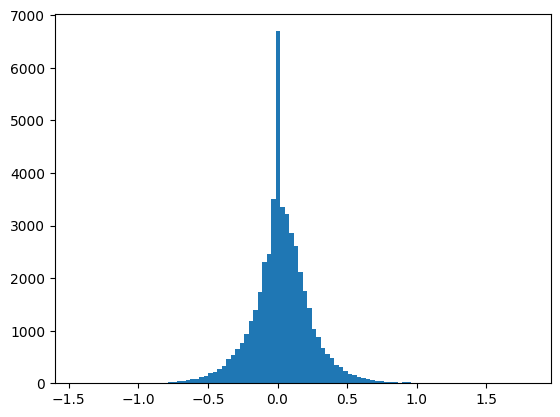

In [38]:
_ = plt.hist(W.flatten(), bins=100)

In [40]:
np.abs(W).max()

1.8015668

In [57]:
Wi = (W * 1000).astype(np.int32)

In [59]:
Wi

array([[   2,    7,    0, ..., -625, -385, -311],
       [ -14,   -7,  -13, ...,  326,   56, -207],
       [  -5,   17,  -10, ..., -622, -306, -556],
       ...,
       [   6,    3,  -13, ...,  -70,  -71, -163],
       [   6,  -10,    6, ..., -414, -375, -323],
       [  13,  -17,  -16, ..., -288,   17,  -83]], dtype=int32)

In [30]:
batch_size = 30
cases = 4
features = 64

# Generate some fake data.
data = torch.tensor(np.random.randn(cases, batch_size, features))
idx = torch.tensor(np.random.randint(low=0, high=cases, size=batch_size))

# Index into the data of shape [batch_size, cases, features], getting a result of shape [batch_size, features].
# This is the same as:
#   result = np.zeros((batch_size, features))
#   for i in range(batch_size):
#       result[i] = data[i, idx[i]]
result = data[idx, torch.arange(batch_size)]


In [31]:
result.shape

torch.Size([30, 64])

In [33]:
idx

tensor([3, 1, 2, 1, 1, 1, 0, 1, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 1, 0, 0, 3, 3, 3,
        1, 1, 1, 3, 0, 1])

In [36]:
result[0] == data[3, 0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])